In [1]:

root_dir = './'

import sys
sys.path.append(root_dir)
import numpy as np
import pandas as pd
import neural_tape_controller
import optimize
import pickle
import torch
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from PIL import Image, ImageDraw,ImageFont
from matplotlib import pyplot as plt
#Положительные числа - положительные награды.
root = root_dir

In [21]:
import matplotlib.pyplot as plt

# Assuming the reward_history is the output of the train_ppo function
def plot_total_rewards(reward_history):
    plt.figure(figsize=(10, 6))
    plt.plot(reward_history, marker='o', linestyle='-', label="Total Rewards per Epoch")
    plt.title("PPO Training Progress")
    plt.xlabel("Epoch")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Описание игровых действий

In [7]:
def encode_simple_colors(X):
  #как сделать простое кодирование? Ну давай разобьём картинку тремя разными сетками и измерим яркость
  #на входе одиночная картинка
  y_lst = []
  sz = np.shape(X)
  for color_channel in range(3):
    count_squares = 10
    for i in range(count_squares):
      for j in range(count_squares):
        x = X[int(i*sz[0]/count_squares):int((i+1)*sz[0]/count_squares), int(j*sz[1]/count_squares):int((j+1)*sz[1]/count_squares),color_channel]
        y_lst.append(np.nanmean(x))

    count_squares = 7
    for i in range(count_squares):
      for j in range(count_squares):
        x = X[int(i*sz[0]/count_squares):int((i+1)*sz[0]/count_squares), int(j*sz[1]/count_squares):int((j+1)*sz[1]/count_squares),color_channel]
        y_lst.append(np.nanmean(x))

    count_squares = 3
    for i in range(count_squares):
      for j in range(count_squares):
        x = X[int(i*sz[0]/count_squares):int((i+1)*sz[0]/count_squares), int(j*sz[1]/count_squares):int((j+1)*sz[1]/count_squares),color_channel]
        y_lst.append(np.nanmean(x))

  #размер: 474(10**2 + 7**2 + 3**2)*3
  return np.array(y_lst)

In [8]:
def white_to_transparency(img):
    x = np.asarray(img.convert('RGBA')).copy()
    x[:, :, 3] = (255 * (x[:, :, :3] != 255).any(axis=2)).astype(np.uint8)
    return Image.fromarray(x)
class strat_game():
  def __init__(self):
    self.field = np.round((np.random.rand(48,48)**150)*12)
    self.money = [50,50]
    self.units = []
    #unit: type,hp,maxhp,cooldown,t,team,resourse,dv,r,armour_type, att_range, att_type, vx,vy,x,y, target
    self.unit_db = {}
    #armour_type: inf, cavalry, heavy_inf
    #att_type: miner, pike, arrow, sword, heal
    unit_type = {'type':'worker','maxhp':1,'cooldown':2,'armour_type':'inf', 'att_type':'miner', 'r':0.1,'dv':0.9,'att_range':1,'price':7}
    self.unit_db['worker']=unit_type
    unit_type = {'type':'pikeman','maxhp':2,'cooldown':5,'armour_type':'inf', 'att_type':'pike', 'r':0.1,'dv':0.9,'att_range':4,'price':5}
    self.unit_db['pikeman']=unit_type
    unit_type = {'type':'swordsman','maxhp':2,'cooldown':4,'armour_type':'heavy_inf', 'att_type':'sword', 'r':0.1,'dv':0.7,'att_range':1,'price':7}
    self.unit_db['swordsman']=unit_type
    unit_type = {'type':'archer','maxhp':1.5,'cooldown':14,'armour_type':'inf','att_type':'arrow', 'r':0.1,'dv':0.9,'att_range':15,'price':7}
    self.unit_db['archer']=unit_type
    unit_type = {'type':'medic','maxhp':1.6,'cooldown':12,'armour_type':'inf','att_type':'heal', 'r':0.1,'dv':1.1,'att_range':1,'price':7}
    self.unit_db['medic']=unit_type
    unit_type = {'type':'knight','maxhp':4,'cooldown':2,'armour_type':'cavalry','att_type':'sword', 'r':0.3,'dv':1.9,'att_range':1.3,'price':16}
    self.unit_db['knight']=unit_type

    self.sprite_base = {}

    if 0:
      self.add_unit('pikeman',(1,10),0)
      self.add_unit('pikeman',(1,20),0)
      self.add_unit('medic',(1,30),0)
      self.add_unit('archer',(1,40),0)
      self.add_unit('swordsman',(1,45),0)
      self.add_unit('knight',(1,35),0)

      self.add_unit('worker',(40,10),1)
      self.add_unit('worker',(40,20),1)
      self.add_unit('medic',(40,30),1)
      self.add_unit('archer',(40,40),1)
      self.add_unit('swordsman',(40,45),1)
      self.add_unit('knight',(40,35),1)
  def get_sprite(self,sprite_name):
    if not(sprite_name in self.sprite_base.keys()):
      self.sprite_base[sprite_name] = Image.open(root+'sprites/'+ sprite_name+'.bmp')#загрузить картинку. Это bmp, пиксель-арт. Белые точки игнорировать
      self.sprite_base[sprite_name] = white_to_transparency(self.sprite_base[sprite_name])
    return self.sprite_base[sprite_name]

  def add_unit(self,unit_type,coords,team):
    unit = {}
    unit['id'] = len(self.units)
    unit['x'],unit['y']=coords
    for key in self.unit_db[unit_type].keys():
      unit[key]=self.unit_db[unit_type][key]
    unit['hp']=unit['maxhp']
    unit['t']=0
    unit['target']=None
    unit['team']=team
    self.units.append(unit)
  def step_env(self,draw=False):
    if 1:
        scale = 6
        #нарисовать землю
        im = Image.new('RGB', (np.shape(self.field)[0]*scale, np.shape(self.field)[1]*scale), (0, 64, 0))
        dr = ImageDraw.Draw(im)
        #нарисовать золото
        for x in range(np.shape(self.field)[0]):
          for y in range(np.shape(self.field)[1]):
            if self.field[x,y]>0:
              if self.field[x,y]<2:
                color = "green"
              elif self.field[x,y]<4:
                color = "lime"
              elif self.field[x,y]<7:
                color = "gold"
              else:
                color = "yellow"
              shape = [((x-0.5)*scale, (y-0.5)*scale), ((x+0.5)*scale, (y+0.5)*scale)]
              dr.rectangle(shape, fill=color)
              sprite = self.get_sprite("gold")
              sprite = sprite.resize((scale,scale))
              im.paste(sprite,(int((x-0.5)*scale),int((y-0.5)*scale)),sprite.split()[-1])

    #ходят юниты
    for unit_num in range(len(self.units)):
      unit = self.units[unit_num]
      if unit['hp']>0:
        if 1:
          #нарисовать юнита
          shape = [((unit['x']-0.5)*scale, (unit['y']-0.5)*scale), ((unit['x']+0.5)*scale, (unit['y']+0)*scale)]
          if unit['team']==0:
            team_color = 'red'
          else:
            team_color = 'blue'
          dr.rectangle(shape, fill=team_color)
          sprite = self.get_sprite(unit['type'])
          if unit['team']==1:
            sprite =  sprite.transpose(Image.FLIP_LEFT_RIGHT)
          im.paste(sprite,(int(unit['x']*scale),int(unit['y']*scale)),sprite.split()[-1])

        unit['t']+=1
        #вначале каждый обновляет себе цель. Это затратно, так что пусть будет вероятностно
        if (np.random.rand()<0.3) or not ('tgt' in unit.keys()):
          team = unit['team']
          if unit['att_type']!='miner':
            unit['trg'] = None
            close_dist = 1e10
            for unit_trg_num in range(len(self.units)):
              unit_trg = self.units[unit_trg_num]
              if (unit_trg['hp']>0):
                if ((unit['att_type']=='heal') and (unit_trg['team']==team) and (unit_trg['hp']<unit_trg['maxhp']))  or  ((unit['att_type']!='heal') and (unit_trg['team']!=team)):
                  dist = np.abs(unit_trg['x']-unit['x'])+np.abs(unit_trg['y']-unit['y'])
                  if dist<close_dist:
                    close_dist=dist
                    unit['trg'] = unit_trg_num
                    unit['trg_x'] = unit_trg['x']
                    unit['trg_y'] = unit_trg['y']
          else:
            trg_x=-1
            trg_y=-1
            for radius in range(np.shape(self.field)[0]):
              x_min = int(np.max([0,unit['x']-radius]))
              x_max = int(np.min([np.shape(self.field)[0],unit['x']+radius]))
              y_min = int(np.max([0,unit['y']-radius]))
              y_max = int(np.min([np.shape(self.field)[0],unit['y']+radius]))
              for x in range(x_min,x_max):
                for y in [y_min,y_max-1]:
                  if self.field[x,y]>0:
                    #нашёл
                    trg_x = x
                    trg_y = y
                    break
                if trg_x>=0:
                    break
              if trg_x>=0:
                break
              for y in range(y_min,y_max):
                for x in [x_min,x_max-1]:
                  if self.field[x,y]>0:
                    #нашёл
                    trg_x = x
                    trg_y = y
                    break
                if trg_x>=0:
                    break
            unit['trg'] = -1
            unit['trg_x'] = trg_x
            unit['trg_y'] = trg_y
      if unit['hp']>0:
          #затем делают шаг в сторону цели, если дистанция недостаточна для атаки
          if not (unit['trg']) is None:
            if unit['trg']!=-1:#рабочий
              unit['trg_x'] = self.units[unit['trg']]['x']
              unit['trg_y'] = self.units[unit['trg']]['y']
            dx = unit['trg_x']-unit['x']
            dy = unit['trg_y']-unit['y']
            dist = np.abs(dx)+np.abs(dy)
            if dist>unit['att_range']:
              if dist>unit['dv']:
                dx/=dist
                dy/=dist
                dx*=unit['dv']
                dy*=unit['dv']
              else:
                dx/=dist
                dy/=dist
                dx*=unit['dv']/2
                dy*=unit['dv']/2
              #делают шаг, если поле не блокировано
              locked = False
              for unit_locker in self.units:
                if (unit_locker['hp']>0) and (unit_locker['id']!=unit['id']):
                  dist_locker = np.abs(unit_locker['x']-unit['x']-dx)+np.abs(unit_locker['y']-unit['y']-dy)
                  if dist_locker<unit['r']+unit_locker['r']:
                    locked=True
                    break
              if not locked:
                unit['x']+=dx
                unit['y']+=dy
            else:
              #иначе атакуют
              if unit['t']>=unit['cooldown']:
                unit['t']=0
                if unit['att_type']=='miner':
                  gain = np.min([2,self.field[unit['trg_x'],unit['trg_y']]])
                  self.field[unit['trg_x'],unit['trg_y']]-=gain
                  self.money[unit['team']]+=gain
                elif unit['att_type']=='heal':
                  self.units[unit['trg']]['hp'] = self.units[unit['trg']]['maxhp']
                else:
                  #обычная атака
                  armour = self.units[unit['trg']]['armour_type']
                  att_type = unit['att_type']
                  coef = 1
                  if (armour=='cavalry') and (att_type=='arrow'):
                    coef=0.2
                  elif (armour=='cavalry') and (att_type=='pike'):
                    coef = 5
                  elif (armour=='heavy_inf') and ((att_type=='pike') or (att_type=='arrow')):
                    coef=0.4
                  self.units[unit['trg']]['hp']-=coef

                  if att_type=='arrow':
                    #нарисовать стрелу
                    x_start = unit['x']*scale
                    y_start = unit['y']*scale
                    x_end = unit['trg_x']*scale
                    y_end = unit['trg_y']*scale
                    arr_len = scale*1.5
                    x_start = (x_start+x_end)/2
                    y_start = (y_start+y_end)/2
                    dx = x_end-x_start
                    dy = y_end-y_start
                    dist = np.abs(dx)+np.abs(dy)
                    dx/=dist
                    dy/=dist
                    dx*=arr_len
                    dy*=arr_len
                    dr.line((x_start,y_start, x_start+dx,y_start+dy), fill="silver",width=1)

    if 1:
      #число денег
      dr.text((1, 1),f"{int(self.money[0])}",'red')
      dr.text((np.shape(self.field)[1]*scale-27,1),f"{int(self.money[1])}",'blue')
      if draw:
        im=im.resize((900,900))
        globals()['video'].append(im)
        #plt.rcParams["figure.figsize"] = (20,20)
        #plt.imshow(im)
        #plt.show()
    return im
  def action(self,team,action_vector):
    #какие вообще варианты, что делать? Нанимать юнитов, только и всего
    argm = np.argmax(action_vector[:6])#что нанимать
    units_d = ['worker','pikeman','swordsman','archer','medic','knight']
    if action_vector[argm]>0:#нанимать ли
      if self.money[team]>=self.unit_db[units_d[argm]]['price']:
        self.money[team]-=self.unit_db[units_d[argm]]['price']
        #куда? Зона найма - это поле 50 на 500
        x = np.shape(self.field)[0]/10*action_vector[6]
        y = np.shape(self.field)[0]*action_vector[7]
        if x<2:
          x=2
        if x>np.shape(self.field)[0]/10-2:
          x=np.shape(self.field)[0]/10-2
        if y<2:
          y=2
        if y>np.shape(self.field)[0]-2:
          y=np.shape(self.field)[0]-2
        if team==1:
          x = np.shape(self.field)[0]-x
        self.add_unit(units_d[argm],(x,y),team)

In [9]:
def single_game(players,seed=0,rounds=1000,draw=False):
  np.random.seed(seed)
  game = strat_game()
  for t in range(rounds):
    img = game.step_env(draw=draw)
    if t%7==0:
      #ходят игроки. По одному действию
      action_vector = players[0].act(img,game,team=0)
      game.action(0,action_vector)
      action_vector = players[1].act(img,game,team=1)
      game.action(1,action_vector)
  scores = game.money
  #за кем поле боя?
  player1_units=0
  player2_units=0
  player2_units_with_dead=0
  for unit in game.units:
    if unit['team']==1:
        player2_units_with_dead+=1
    if unit['hp']>0:
      if unit['team']==0:
        player1_units+=1
      elif unit['team']==1:
        player2_units+=1
    if (player2_units>0) and (player1_units>0):
      break

  return scores,(player1_units,player2_units),game.field,player2_units_with_dead

In [10]:
class player_only_workers():
  def __init__(self):
    self.tact = 0
  def act(self,img,game,team):
    x= np.random.rand()
    y= np.random.rand()
    if self.tact<=4:
      #рабочий
      action_vector = [1,0,0,0,0,0,x,y]
    else:
      action_vector = [0,0,0,0,0,0,0,0]
    self.tact+=1
    return action_vector
class player_few_units():
  def __init__(self):
    self.tact = 0
  def act(self,img,game,team):
    x= np.random.rand()
    y= np.random.rand()
    if self.tact<=3:
      #рабочий
      action_vector = [1,0,0,0,0,0,x,y]
    elif self.tact<=5:
      #лучник
      action_vector = [0,0,0,1,0,0,x,y]
    else:
      action_vector = [0,0,0,0,0,0,0,0]
    self.tact+=1
    return action_vector
class player_knight():
  def __init__(self):
    self.tact = 0
  def act(self,img,game,team):
    x= np.random.rand()
    y= np.random.rand()
    if self.tact==3:
      #всадник
      action_vector = [0,0,0,0,0,1,x,y]
    elif self.tact<=5:
      #рабочий
      action_vector = [1,0,0,0,0,0,x,y]
    else:
      action_vector = [0,0,0,0,0,0,0,0]
    self.tact+=1
    return action_vector

class player_many_knights():
  def __init__(self):
    self.tact = 0
  def act(self,img,game,team):
    x= np.random.rand()
    y= np.random.rand()
    if self.tact<=3:
      #всадник
      action_vector = [0,0,0,0,0,1,x,y]
    elif self.tact<=8:
      #рабочий
      action_vector = [1,0,0,0,0,0,x,y]
    else:
      action_vector = [0,0,0,0,0,0,0,0]
    self.tact+=1
    return action_vector

class player_balance():
  def __init__(self):
    pass
  def act(self,img,game,team):
    x= np.random.rand()
    y= np.random.rand()
    #если у противника перевес по юнитам, создать юнита. Если нет рабочих, создать рабочего
    our_workers = 0
    enemy_mil_units = 0
    our_mil_units = 0
    for unit in game.units:
      if unit['hp']>0:
        if unit['team']!=team:
          if (unit['type']!='worker') and (unit['type']!='medic'):
            enemy_mil_units+=1
        elif (unit['type']!='worker') and (unit['type']!='medic'):
          our_mil_units+=1
        elif unit['type']=='worker':
          our_workers+=1
    action_vector = [0,0,0,0,0,0,0,0]

    if our_workers==0:
      #рабочий
      action_vector = [1,0,0,0,0,0,x,y]
    if our_mil_units<enemy_mil_units-1:
      #стрелок
      action_vector = [0,0,1,0,0,0,x,y]
    if our_mil_units==0:
      #всадник
      action_vector = [0,0,0,0,0,1,x,y]
    return action_vector

class player_adaptive():
  def __init__(self):
    pass
  def act(self,img,game,team):
    x= np.random.rand()
    y= np.random.rand()
    #если у противника перевес по юнитам, создать юнита. Если нет рабочих, создать рабочего
    our_workers = 0
    enemy_mil_units = 0
    enemy_spear = 0
    enemy_archer = 0
    enemy_cavalry = 0
    our_mil_units = 0
    for unit in game.units:
      if unit['hp']>0:
        if unit['team']!=team:
          if (unit['type']!='worker') and (unit['type']!='medic'):
            enemy_mil_units+=1
            if unit['type']=='pikeman':
              enemy_spear+=1
            elif unit['type']=='archer':
              enemy_archer+=1
            elif unit['type']=='knight':
              enemy_cavalry+=2
        elif (unit['type']!='worker') and (unit['type']!='medic'):
          our_mil_units+=1
        elif unit['type']=='worker':
          our_workers+=1
    action_vector = [0,0,0,0,0,0,0,0]

    enemy_force_vector = [enemy_spear,enemy_archer,enemy_cavalry]
    amax = np.argmax(enemy_force_vector)

    if our_mil_units==0:
      if amax==0:
        if enemy_spear==enemy_cavalry:
          #мечник
          action_vector = [0,0,1,0,0,0,x,y]
        else:
          #лучник
          action_vector = [0,0,0,1,0,0,x,y]
      elif amax==1:
        #всадник
        action_vector = [0,0,0,0,0,1,x,y]
      elif amax==2:
        #пикинер
        action_vector = [0,1,0,0,0,0,x,y]
    elif our_workers==0:
      #рабочий
      action_vector = [1,0,0,0,0,0,x,y]
    elif our_mil_units<enemy_mil_units:
      if amax==0:
        if enemy_spear==enemy_cavalry:
          #мечник
          action_vector = [0,0,1,0,0,0,x,y]
        else:
          #лучник
          action_vector = [0,0,0,1,0,0,x,y]
      elif amax==1:
        #всадник
        action_vector = [0,0,0,0,0,1,x,y]
      elif amax==2:
        #пикинер
        action_vector = [0,1,0,0,0,0,x,y]
    return action_vector

class player_heavy():
  def __init__(self):
    pass
  def act(self,img,game,team):
    x= np.random.rand()
    y= np.random.rand()
    #если у противника перевес по юнитам, создать юнита. Если нет рабочих, создать рабочего
    our_workers = 0
    enemy_mil_units = 0
    our_mil_units = 0
    for unit in game.units:
      if unit['hp']>0:
        if unit['team']!=team:
          if (unit['type']!='worker') and (unit['type']!='medic'):
            enemy_mil_units+=1
        elif (unit['type']!='worker') and (unit['type']!='medic'):
          our_mil_units+=1
        elif unit['type']=='worker':
          our_workers+=1
    action_vector = [0,0,0,0,0,0,0,0]

    if our_workers==0:
      #рабочий
      action_vector = [1,0,0,0,0,0,x,y]
    if our_mil_units<enemy_mil_units:
      #мечник
      action_vector = [0,0,1,0,0,0,x,y]
    return action_vector
class player_archer():
  def __init__(self):
    pass
  def act(self,img,game,team):
    x= np.random.rand()
    y= np.random.rand()
    #если у противника перевес по юнитам, создать юнита. Если нет рабочих, создать рабочего
    our_workers = 0
    enemy_mil_units = 0
    our_mil_units = 0
    for unit in game.units:
      if unit['hp']>0:
        if unit['team']!=team:
          if (unit['type']!='worker') and (unit['type']!='medic'):
            enemy_mil_units+=1
        elif (unit['type']!='worker') and (unit['type']!='medic'):
          our_mil_units+=1
        elif unit['type']=='worker':
          our_workers+=1
    action_vector = [0,0,0,0,0,0,0,0]

    if our_workers==0:
      #рабочий
      action_vector = [1,0,0,0,0,0,x,y]
    if our_mil_units<=enemy_mil_units:
      #лучник
      action_vector = [0,0,0,1,0,0,x,y]
    return action_vector

class player_only_archer():
  def __init__(self):
    pass
  def act(self,img,game,team):
    x= np.random.rand()
    y= np.random.rand()

    #лучник
    action_vector = [0,0,0,1,0,0,x,y]
    return action_vector

class player_army():
  def __init__(self):
    self.tact = 0
  def act(self,img,game,team):
    x= np.random.rand()
    y= np.random.rand()
    action_vector = [0,0,0,0,0,0,0,0]
    if self.tact==1:
      #рабочий
      action_vector = [1,0,0,0,0,0,x,y]
    elif self.tact==2:
      #мечник
      action_vector = [0,0,1,0,0,0,x,y]
    elif self.tact==3:
      #медик
      action_vector = [0,0,0,0,1,0,x,y]
    elif self.tact==4:
      #лучник
      action_vector = [0,0,0,1,0,0,x,y]
    else:
      our_workers = 0
      enemy_mil_units = 0
      our_mil_units = 0
      for unit in game.units:
        if unit['hp']>0:
          if unit['team']!=team:
            if (unit['type']!='worker') and (unit['type']!='medic'):
              enemy_mil_units+=1
          elif (unit['type']!='worker') and (unit['type']!='medic'):
            our_mil_units+=1
          elif unit['type']=='worker':
            our_workers+=1
      if our_workers==0:
        #рабочий
        action_vector = [1,0,0,0,0,0,0,0]
      if enemy_mil_units>our_mil_units:
        #лучник
        action_vector = [0,0,0,1,0,0,0,0]
    self.tact+=1
    return action_vector

In [11]:
class StratGameAdapter:
    def __init__(self, game):
        self.game = game  # Внутри хранится объект вашей игры

    def reset(self):
        # Пересоздание игры (инициализация нового объекта strat_game)
        self.game = strat_game()
        # Здесь создается начальное состояние, например, вектор признаков поля
        initial_state = np.ravel(self.game.field)  # Например, раскладываем поле в одномерный массив
        return initial_state

    def step(self, action_vector, team):
        # Выполнение действия и обновление среды
        self.game.action(team, action_vector)
        img = self.game.step_env(draw=False)  # Один шаг игры
        # Возврат состояния, награды, флага завершения игры и дополнительной информации
        next_state = np.ravel(self.game.field)
        reward = self.game.money[team]  # Награда на основе денег команды
        # print(f"Reward: {reward}, Team: {team}")
        done = False  # Ваша логика завершения игры
        return next_state, reward, done, {}

    def render(self):
        # Визуализация игры (если нужно)
        self.game.step_env(draw=True)

# PPO

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class PPOActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PPOActorCritic, self).__init__()

        # Actor network (уменьшили размер до 64 нейронов)
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU (),
            nn.Linear(128, 128),
            nn.ReLU (),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )

        # Critic network (уменьшили размер до 64 нейронов)
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU (),
            nn.Linear(128, 128),
            nn.ReLU (),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        action_probs = self.actor(state)
        value = self.critic(state)
        return action_probs, value

def train_ppo(env, agent, epochs, gamma=0.999, epsilon=0.01, lr=1e-5, max_iters=500, batch_size=64):
    optimizer = optim.Adam(agent.parameters(), lr=lr)
    reward_history = []

    for epoch in range(epochs):
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).to(device)

        log_probs_old = []
        values = []
        rewards = []
        states = []
        actions = []

        total_reward = 0
        iters = 0
        done = False

        while not done and iters < max_iters:
            iters += 1
            action_probs, value = agent(state)
            dist = torch.distributions.Categorical(action_probs)
            action = dist.sample()

            # Добавим логику для случайных действий (временная проверка)
            action_vector = np.zeros(8)
            action_vector[action.item()] = 1
            action_vector[6] = np.random.rand()
            action_vector[7] = np.random.rand()

            next_state, reward, done, _ = env.step(action_vector, 0)
            total_reward += reward  # Считаем общее вознаграждение

            # Сохранение данных для обновления
            log_probs_old.append(dist.log_prob(action))
            values.append(value)
            rewards.append(reward)
            states.append(state)
            actions.append(action)

            state = torch.tensor(next_state, dtype=torch.float32).to(device)

            # Выполняем обновление, если набрано достаточно данных
            if len(rewards) >= batch_size:
                update_ppo(agent, optimizer, log_probs_old, values, rewards, states, actions, gamma, epsilon)
                log_probs_old, values, rewards, states, actions = [], [], [], [], []

        # Сохраняем общую награду для отладки
        reward_history.append(total_reward)
        print(f"Epoch {epoch}, Total Reward: {total_reward:.2f}")

    return agent, reward_history


def update_ppo(agent, optimizer, log_probs_old, values, rewards, states, actions, gamma, epsilon):
    # Преобразование данных в тензоры
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    log_probs_old = torch.stack(log_probs_old).to(device)
    values = torch.cat(values).squeeze().to(device)

    # Расчёт возвращённых наград (returns)
    returns = []
    Gt = 0
    for reward in reversed(rewards):
        Gt = reward + gamma * Gt
        returns.insert(0, Gt)
    returns = torch.tensor(returns, dtype=torch.float32).to(device)

    # Нормализация возвратов
    returns = (returns - returns.mean()) / (returns.std() + 1e-5)
    advantages = returns - values  # Вычисление преимущества

    states_tensor = torch.stack(states).detach()
    actions_tensor = torch.stack(actions).detach()
    advantages_tensor = advantages.detach()

    # Множество обновлений на одном батче
    for _ in range(10):
        action_probs, value = agent(states_tensor)
        dist = torch.distributions.Categorical(action_probs)
        log_probs = dist.log_prob(actions_tensor)

        # Вычисление энтропии
        entropy = dist.entropy().mean()

        # PPO Loss
        ratios = torch.exp(log_probs - log_probs_old.detach())
        surr1 = ratios * advantages_tensor
        surr2 = torch.clamp(ratios, 1 - epsilon, 1 + epsilon) * advantages_tensor
        actor_loss = -torch.min(surr1, surr2).mean()

        critic_loss = nn.MSELoss()(value.squeeze(), returns)

        # Общая функция потерь
        loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy  # Добавлено вычитание энтропии для увеличения разнообразия действий

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # # Отладочная информация
        # print(f"Actor loss: {actor_loss.item()}, Critic loss: {critic_loss.item()}, Entropy: {entropy.item()}")

# Гиперпараметры
state_dim = 2304  # Размерность состояния
action_dim = 8  # Размерность действия (набор возможных действий)
epochs = 10  # Уменьшено для тестирования
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Инициализация среды и модели
env = StratGameAdapter(strat_game())  # Ваша стратегическая игра
agent = PPOActorCritic(state_dim, action_dim).to(device)

# Обучение
agent, reward_history = train_ppo(env, agent, epochs)

Epoch 0, Total Reward: 1525.00
Epoch 1, Total Reward: 1623.00
Epoch 2, Total Reward: 1747.00
Epoch 3, Total Reward: 1363.00
Epoch 4, Total Reward: 677.00
Epoch 5, Total Reward: 1633.00
Epoch 6, Total Reward: 1578.00
Epoch 7, Total Reward: 1584.00
Epoch 8, Total Reward: 1675.00
Epoch 9, Total Reward: 1961.00


In [25]:
reward_history_0 = [1525, 1623, 1747, 1363, 677, 1633, 1578, 1584, 1675, 1961]

/var/folders/x1/tsx2fh_s2x5c_mzwjz9bvj240000gn/T/ipykernel_71112/3508681892.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


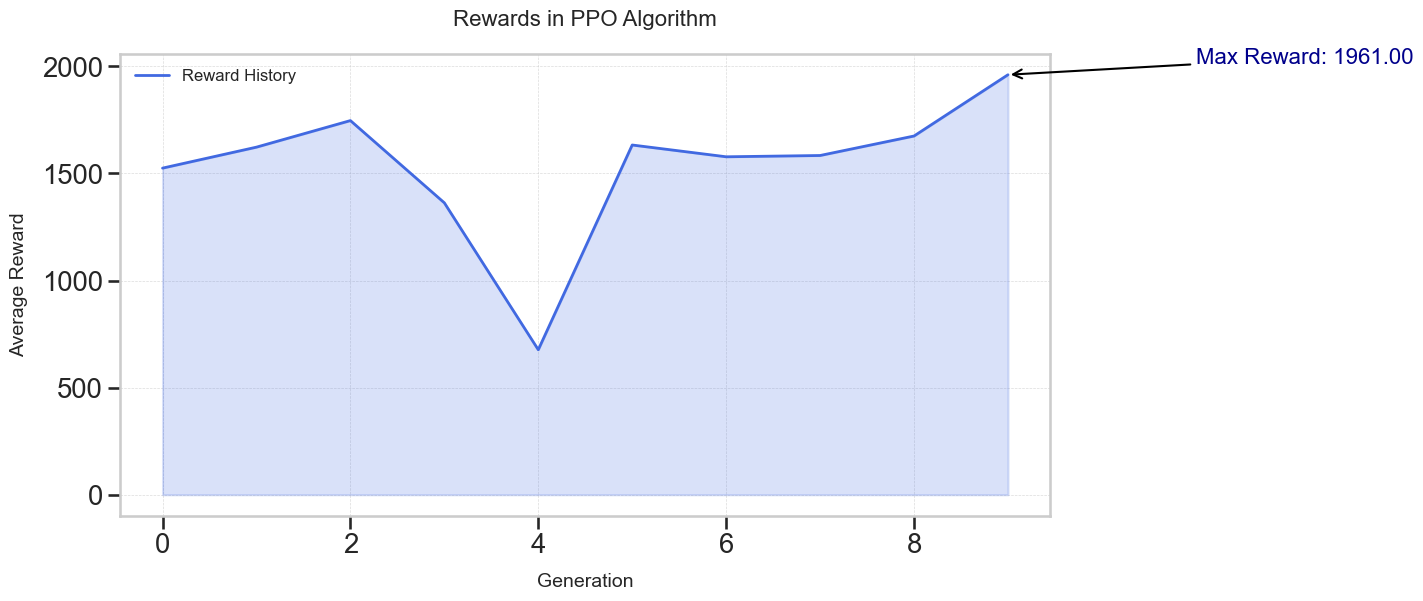

In [28]:
plt.style.use('seaborn-whitegrid')
sns.set_context('talk', font_scale=1.2)

plt.figure(figsize=(12, 6))
plt.plot(reward_history_0, color='royalblue', linewidth=2, label='Reward History')
plt.fill_between(range(len(reward_history_0)), reward_history_0, color='royalblue', alpha=0.2)

plt.xlabel('Generation', fontsize=14, labelpad=10)
plt.ylabel('Average Reward', fontsize=14, labelpad=10)
plt.title('Rewards in PPO Algorithm', fontsize=16, pad=20)
plt.legend(fontsize=12)
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

max_reward = max(reward_history_0)
max_index = reward_history_0.index(max_reward)
plt.annotate(f'Max Reward: {max_reward:.2f}', 
             xy=(max_index, max_reward), 
             xytext=(max_index + 2, max_reward + 50),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=16,
             color='darkblue')

plt.savefig('ppo.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

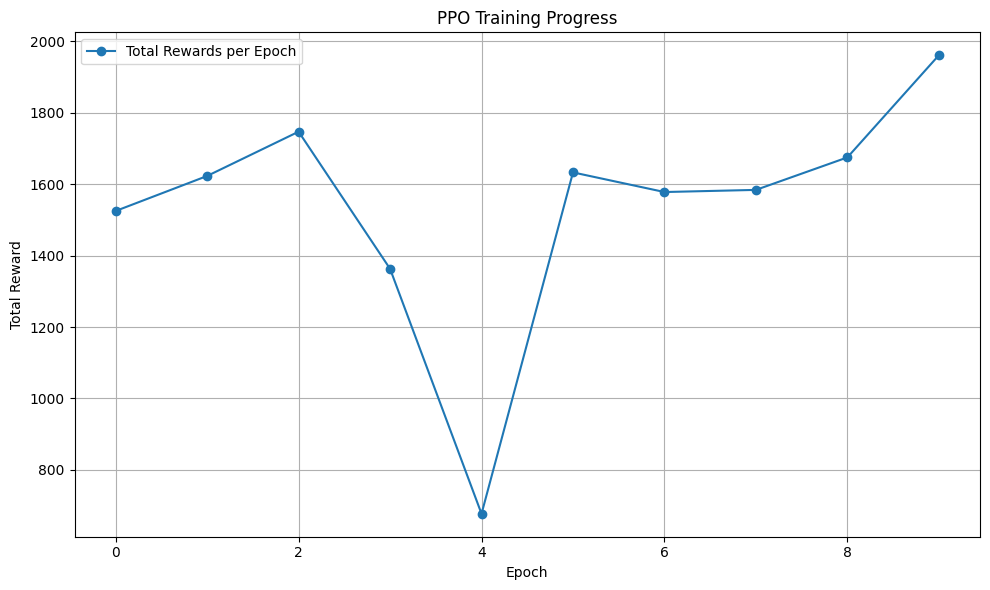

In [ ]:
import matplotlib.pyplot as plt

# Assuming the reward_history is the output of the train_ppo function
def plot_total_rewards(reward_history):
    plt.figure(figsize=(10, 6))
    plt.plot(reward_history, marker='o', linestyle='-', label="Total Rewards per Epoch")
    plt.title("PPO Training Progress")
    plt.xlabel("Epoch")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example: replace this list with actual `reward_history` values
# reward_history = [1006, 508, 971, 746, 830, 678, 938, 1026, 837, 841]
plot_total_rewards(reward_history)

# Actor-Critic

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()

        # Actor network
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),  # Выход для вероятности действия
            nn.Softmax(dim=-1)
        )

        # Critic network
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Выход для оценки состояния
        )

    def forward(self, state):
        action_probs = self.actor(state)
        value = self.critic(state)
        return action_probs, value

def train_actor_critic(env, agent, epochs, gamma=0.99, lr=1e-5, max_iters=500, batch_size=64):
    optimizer = optim.Adam(agent.parameters(), lr=lr)
    reward_history = []

    for epoch in range(epochs):
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).to(device)

        total_reward = 0
        done = False
        iters = 0

        while not done and iters < max_iters:
            iters += 1
            # Прогнозируем вероятность действия и ценность состояния
            action_probs, value = agent(state)
            dist = torch.distributions.Categorical(action_probs)
            action = dist.sample()

            # Преобразуем действие в вектор для игры
            action_vector = np.zeros(8)
            action_vector[action.item()] = 1
            action_vector[6] = np.random.rand()  # Пример случайных значений для координат
            action_vector[7] = np.random.rand()

            # Выполнение действия в среде
            next_state, reward, done, _ = env.step(action_vector, 0)
            total_reward += reward

            # Оценка нового состояния
            next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
            _, next_value = agent(next_state)

            # Расчет преимущества (TD Error)
            advantage = reward + gamma * next_value - value

            # Вычисление потерь для актера и критика
            log_prob = dist.log_prob(action)
            actor_loss = -log_prob * advantage  # Преимущество в Actor

            critic_loss = advantage.pow(2)  # Ошибка в Critic

            # Общая потеря
            loss = actor_loss + 0.5 * critic_loss

            # Обновление параметров
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()

            # Переход к следующему состоянию
            state = next_state

        reward_history.append(total_reward)
        print(f"Epoch {epoch}, Total Reward: {total_reward:.2f}")

    return agent, reward_history


# Гиперпараметры
state_dim = 2304  # Размерность состояния
action_dim = 8    # Размерность действия (набор возможных действий)
epochs = 20       # Уменьшено для тестирования
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Инициализация среды и модели
env = StratGameAdapter(strat_game())  # Ваша стратегическая игра
agent = ActorCritic(state_dim, action_dim).to(device)

# Обучение
agent, reward_history = train_actor_critic(env, agent, epochs)


Epoch 0, Total Reward: 1595.00
Epoch 1, Total Reward: 1291.00
Epoch 2, Total Reward: 1760.00
Epoch 3, Total Reward: 1454.00
Epoch 4, Total Reward: 1773.00
Epoch 5, Total Reward: 1348.00
Epoch 6, Total Reward: 256.00
Epoch 7, Total Reward: 333.00
Epoch 8, Total Reward: 1564.00
Epoch 9, Total Reward: 2024.00
Epoch 10, Total Reward: 649.00
Epoch 11, Total Reward: 1048.00
Epoch 12, Total Reward: 731.00
Epoch 13, Total Reward: 1494.00
Epoch 14, Total Reward: 651.00
Epoch 15, Total Reward: 1588.00
Epoch 16, Total Reward: 2152.00
Epoch 17, Total Reward: 1767.00
Epoch 18, Total Reward: 1370.00
Epoch 19, Total Reward: 1928.00


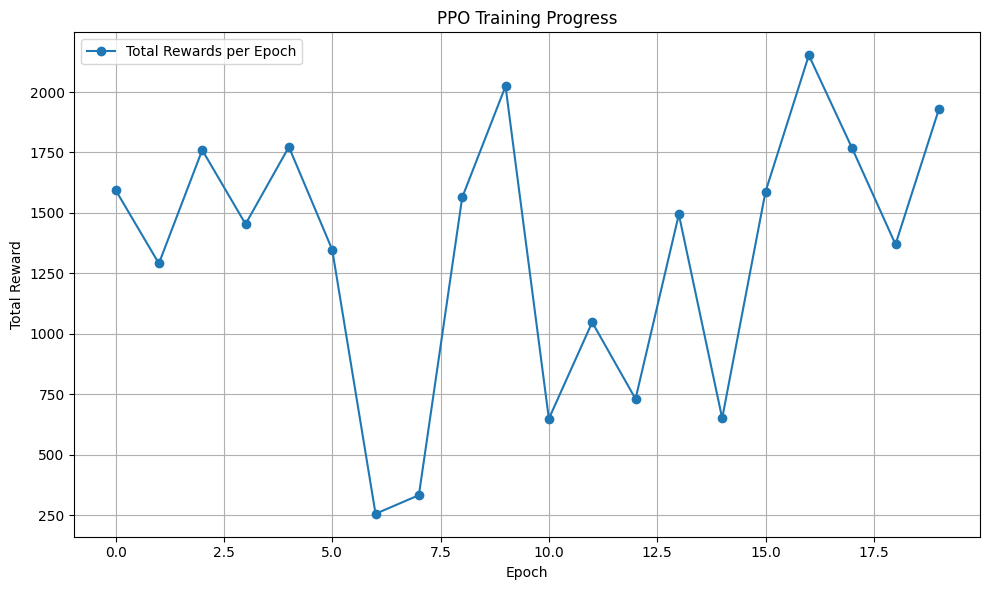

In [15]:


plot_total_rewards(reward_history)

In [18]:
print(reward_history)

[1595.0, 1291.0, 1760.0, 1454.0, 1773.0, 1348.0, 256, 333, 1564.0, 2024.0, 649, 1048, 731, 1494.0, 651, 1588.0, 2152.0, 1767.0, 1370.0, 1928.0]


In [21]:
reward_history_1 = [1595.0, 1291.0, 1760.0, 1454.0, 1773.0, 1348.0, 256, 333, 1564.0, 2024.0, 649, 1048, 731, 1494.0, 651, 1588.0, 2152.0, 1767.0, 1370.0, 1928.0]

/var/folders/x1/tsx2fh_s2x5c_mzwjz9bvj240000gn/T/ipykernel_71112/1385383196.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


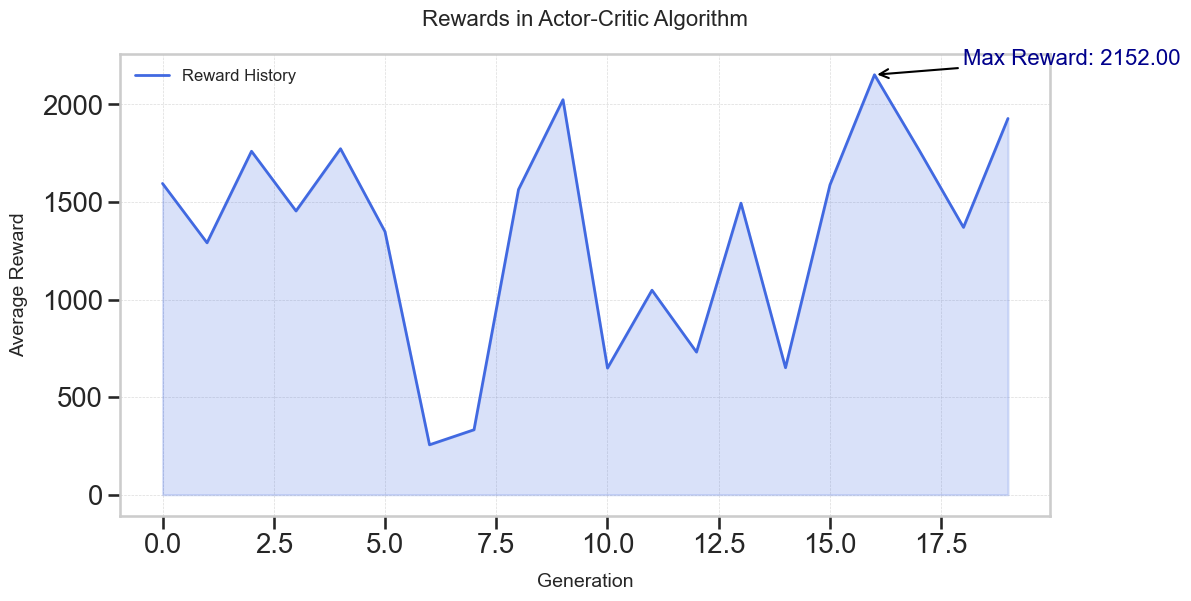

In [22]:
plt.style.use('seaborn-whitegrid')
sns.set_context('talk', font_scale=1.2)

plt.figure(figsize=(12, 6))
plt.plot(reward_history_1, color='royalblue', linewidth=2, label='Reward History')
plt.fill_between(range(len(reward_history_1)), reward_history_1, color='royalblue', alpha=0.2)

plt.xlabel('Generation', fontsize=14, labelpad=10)
plt.ylabel('Average Reward', fontsize=14, labelpad=10)
plt.title('Rewards in Actor-Critic Algorithm', fontsize=16, pad=20)
plt.legend(fontsize=12)
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

max_reward = max(reward_history_1)
max_index = reward_history_1.index(max_reward)
plt.annotate(f'Max Reward: {max_reward:.2f}', 
             xy=(max_index, max_reward), 
             xytext=(max_index + 2, max_reward + 50),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=16,
             color='darkblue')

plt.savefig('ac.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()


# Adjusted Actor Critic

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class AdjustedActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(AdjustedActorCritic, self).__init__()

        # Actor network
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )

        # Critic network
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        action_probs = self.actor(state)
        value = self.critic(state)
        return action_probs, value


def normalize(tensor):
    """Нормализация тензора (например, наград или состояний)."""
    return (tensor - tensor.mean()) / (tensor.std() + 1e-5)


def compute_gae(rewards, values, gamma, lam):
    """Вычисление генерализованного преимущества (GAE)."""
    advantages = []
    advantage = 0
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * (values[t + 1] if t + 1 < len(values) else 0) - values[t]
        advantage = delta + gamma * lam * advantage
        advantages.insert(0, advantage)
    return advantages


def train_adjusted_actor_critic(env, agent, epochs, gamma=0.99, lam=0.95, lr=1e-4, max_iters=500, batch_size=64):
    optimizer = optim.Adam(agent.parameters(), lr=lr)
    reward_history = []

    for epoch in range(epochs):
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).to(device)

        total_reward = 0
        done = False
        iters = 0

        # Буфер для хранения данных
        log_probs = []
        values = []
        rewards = []
        states = []
        actions = []

        while not done and iters < max_iters:
            iters += 1
            # Прогнозируем вероятность действия и ценность состояния
            action_probs, value = agent(state)
            dist = torch.distributions.Categorical(action_probs)
            action = dist.sample()

            # Преобразуем действие в вектор для игры
            action_vector = np.zeros(8)
            action_vector[action.item()] = 1
            action_vector[6] = np.random.rand()
            action_vector[7] = np.random.rand()

            # Выполнение действия в среде
            next_state, reward, done, _ = env.step(action_vector, 0)
            total_reward += reward

            # Сохранение данных
            log_probs.append(dist.log_prob(action))
            values.append(value.item())
            rewards.append(reward)
            states.append(state)
            actions.append(action)

            # Переход к следующему состоянию
            state = torch.tensor(next_state, dtype=torch.float32).to(device)

        # После завершения эпизода:
        # Добавляем значение состояния для последнего шага
        values.append(agent.critic(state).item())

        # Вычисляем GAE и нормализуем преимущества
        advantages = compute_gae(rewards, values, gamma, lam)
        returns = [adv + val for adv, val in zip(advantages, values[:-1])]

        advantages = torch.tensor(advantages, dtype=torch.float32).to(device)
        returns = torch.tensor(returns, dtype=torch.float32).to(device)
        log_probs = torch.stack(log_probs).to(device)
        states_tensor = torch.stack(states).to(device)
        actions_tensor = torch.stack(actions).to(device)

        # Нормализация преимуществ
        advantages = normalize(advantages)

        # Обновления через несколько эпох
        for _ in range(5):
            action_probs, value = agent(states_tensor)
            dist = torch.distributions.Categorical(action_probs)
            log_probs_current = dist.log_prob(actions_tensor)

            # Вычисление потерь
            actor_loss = -torch.mean(log_probs_current * advantages)
            critic_loss = nn.MSELoss()(value.squeeze(), returns)
            entropy_loss = dist.entropy().mean()

            # Итоговая потеря с учетом энтропии
            loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Сохраняем общую награду для отладки
        reward_history.append(total_reward)
        print(f"Epoch {epoch}, Total Reward: {total_reward:.2f}")

    return agent, reward_history


# Гиперпараметры
state_dim = 2304  # Размерность состояния
action_dim = 8    # Размерность действия (набор возможных действий)
epochs = 20       # Увеличено количество эпох
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Инициализация среды и модели
env = StratGameAdapter(strat_game())  # Ваша стратегическая игра
agent = AdjustedActorCritic(state_dim, action_dim).to(device)

# Обучение
agent, reward_history = train_adjusted_actor_critic(env, agent, epochs)


Epoch 0, Total Reward: 711.00
Epoch 1, Total Reward: 1253.00
Epoch 2, Total Reward: 2099.00
Epoch 3, Total Reward: 1719.00
Epoch 4, Total Reward: 1855.00
Epoch 5, Total Reward: 2083.00
Epoch 6, Total Reward: 650.00
Epoch 7, Total Reward: 1200.00
Epoch 8, Total Reward: 1417.00
Epoch 9, Total Reward: 146.00
Epoch 10, Total Reward: 1750.00
Epoch 11, Total Reward: 677.00
Epoch 12, Total Reward: 1697.00
Epoch 13, Total Reward: 2047.00
Epoch 14, Total Reward: 1768.00
Epoch 15, Total Reward: 1728.00
Epoch 16, Total Reward: 1574.00
Epoch 17, Total Reward: 2241.00
Epoch 18, Total Reward: 991.00
Epoch 19, Total Reward: 1654.00


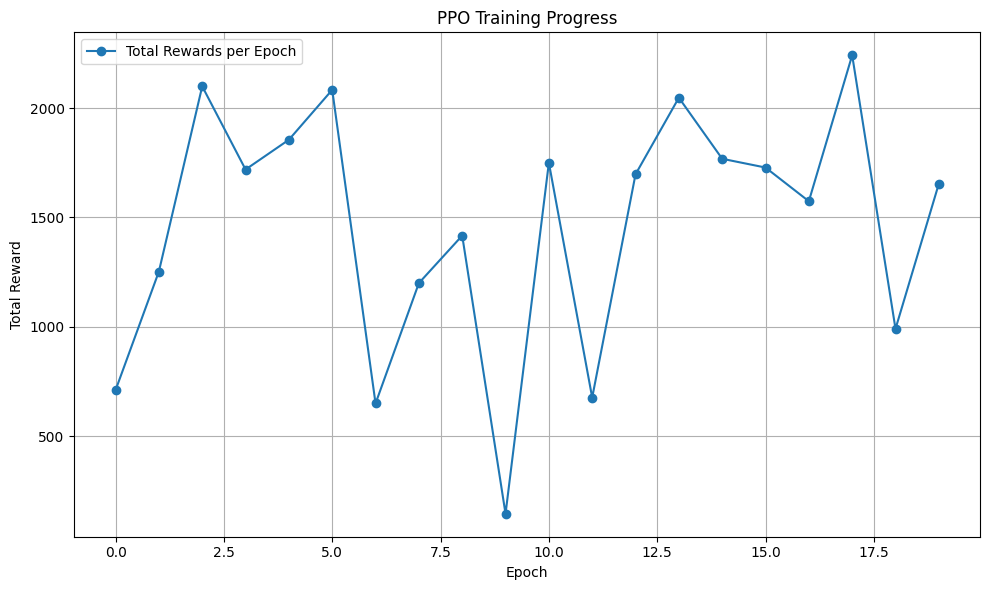

In [22]:
plot_total_rewards(reward_history)

In [24]:
print(reward_history)

[711, 1253.0, 2099, 1719.0, 1855.0, 2083.0, 650, 1200.0, 1417.0, 146, 1750.0, 677, 1697.0, 2047.0, 1768, 1728.0, 1574.0, 2241.0, 991.0, 1654.0]


In [23]:
reward_history_2 = [711, 1253.0, 2099, 1719.0, 1855.0, 2083.0, 650, 1200.0, 1417.0, 146, 1750.0, 677, 1697.0, 2047.0, 1768, 1728.0, 1574.0, 2241.0, 991.0, 1654.0]

/var/folders/x1/tsx2fh_s2x5c_mzwjz9bvj240000gn/T/ipykernel_71112/3911056356.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


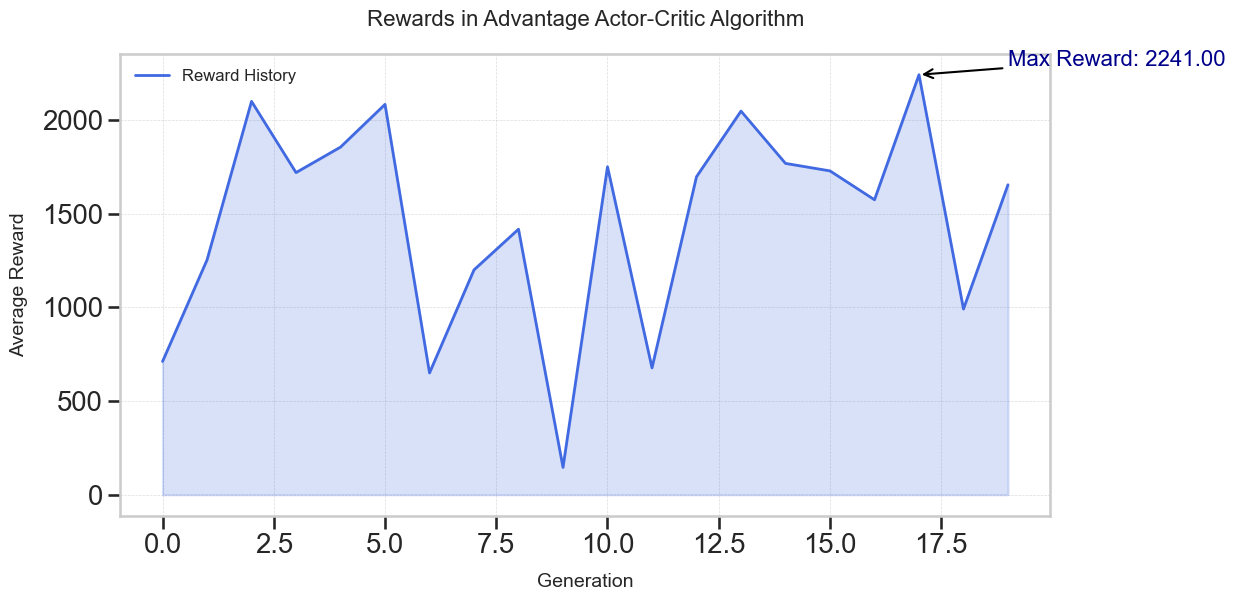

In [24]:
plt.style.use('seaborn-whitegrid')
sns.set_context('talk', font_scale=1.2)

plt.figure(figsize=(12, 6))
plt.plot(reward_history_2, color='royalblue', linewidth=2, label='Reward History')
plt.fill_between(range(len(reward_history_2)), reward_history_2, color='royalblue', alpha=0.2)

plt.xlabel('Generation', fontsize=14, labelpad=10)
plt.ylabel('Average Reward', fontsize=14, labelpad=10)
plt.title('Rewards in Advantage Actor-Critic Algorithm', fontsize=16, pad=20)
plt.legend(fontsize=12)
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

max_reward = max(reward_history_2)
max_index = reward_history_2.index(max_reward)
plt.annotate(f'Max Reward: {max_reward:.2f}', 
             xy=(max_index, max_reward), 
             xytext=(max_index + 2, max_reward + 50),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=16,
             color='darkblue')

plt.savefig('aac.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

## Сравнение моделей

/var/folders/x1/tsx2fh_s2x5c_mzwjz9bvj240000gn/T/ipykernel_71112/46097286.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


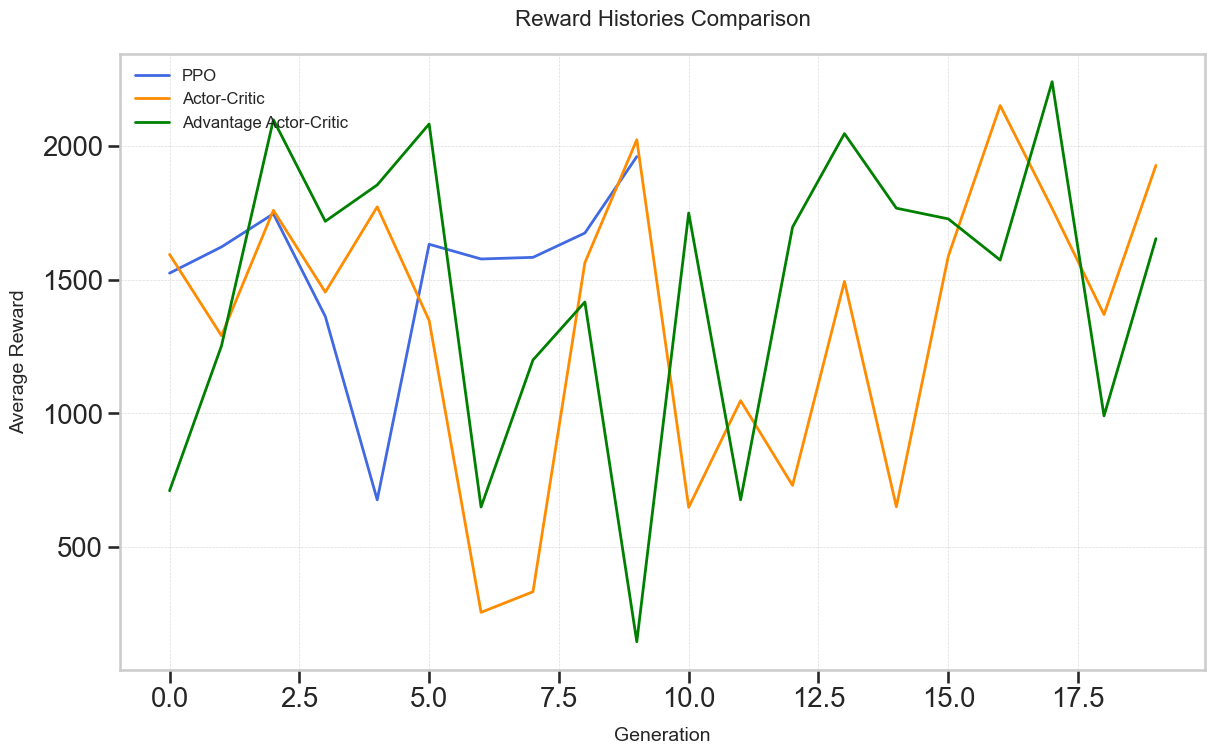

In [30]:
plt.style.use('seaborn-whitegrid')
sns.set_context('talk', font_scale=1.2)

reward_history_0 = [1525, 1623, 1747, 1363, 677, 1633, 1578, 1584, 1675, 1961]
reward_history_1 = [1595.0, 1291.0, 1760.0, 1454.0, 1773.0, 1348.0, 256, 333, 1564.0, 2024.0, 649, 1048, 731, 1494.0, 651, 1588.0, 2152.0, 1767.0, 1370.0, 1928.0]
reward_history_2 = [711, 1253.0, 2099, 1719.0, 1855.0, 2083.0, 650, 1200.0, 1417.0, 146, 1750.0, 677, 1697.0, 2047.0, 1768, 1728.0, 1574.0, 2241.0, 991.0, 1654.0]
# reward_history_3 = [-38.8, 8.00, 11.83, 13.87, 14.76, 14.33, 13.40, 14.66, 14.58, 14.85, 14.85, 14.85, 14.85, 14.85, 14.85, 14.85, 14.85, 14.85, 14.85, 14.85]

plt.figure(figsize=(14, 8))
plt.plot(reward_history_0, label='PPO', linewidth=2, color='royalblue')
plt.plot(reward_history_1, label='Actor-Critic', linewidth=2, color='darkorange')
plt.plot(reward_history_2, label='Advantage Actor-Critic', linewidth=2, color='green')
# plt.plot(reward_history_3, label='Baseline', linewidth=2, color='purple')

plt.xlabel('Generation', fontsize=14, labelpad=10)
plt.ylabel('Average Reward', fontsize=14, labelpad=10)
plt.title('Reward Histories Comparison', fontsize=16, pad=20)
plt.legend(fontsize=12, loc='upper left')
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

plt.savefig('all.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()
